# Load Data

In [1]:
import numpy as np
import os
X = np.load(os.path.join("..", "..", "data", "dog.npz"))["X"]
X.shape

(400, 15)

In [2]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

def get_scores(y_true, y_pred, binary=True):

    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc= auc(fpr, tpr)

    precision_line, recall_line, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall_line, precision_line)
    rmse = root_mean_squared_error(y_true, y_pred)

    if binary:
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="weighted")
        precision = precision_score(y_true, y_pred, average="weighted")
        recall = recall_score(y_true, y_pred, average="weighted")
        mcc = matthews_corrcoef(y_true, y_pred)
    else:
        acc, f1, precision, recall, mcc = None, None, None, None, None

    return {
            "roc_auc":roc_auc, 
            "pr_auc":pr_auc,
            "accuracy":acc,
            "f1":f1,
            "precision":precision,
            "recall":recall,
            "mcc":mcc,
            "rmse":rmse
            }

# Create Training Set and MASK

In [3]:
import sys; sys.path.append(os.path.join("..", "..", "scripts"))
from sample_with_mask import sample_matrix

X, Xtrain, MASK, removed_coords= sample_matrix(X, sample_ratio=0.2, random_state=42, stratify=True)

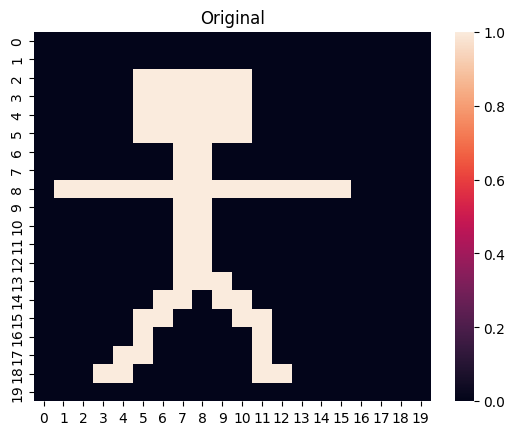

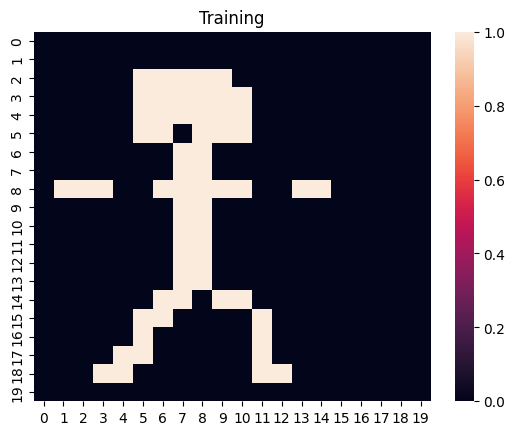

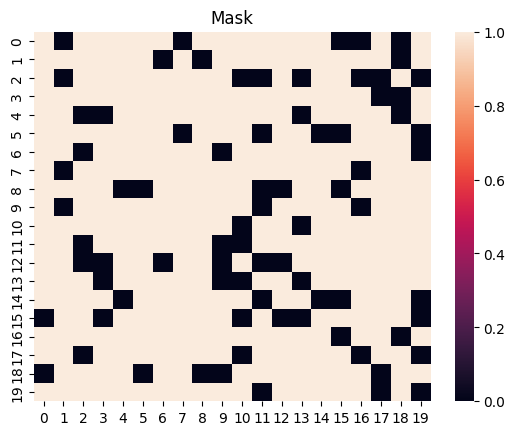

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

target_figure = 1
sns.heatmap(np.reshape(X[:,target_figure], (20,20)))
plt.title("Original")
plt.show()

sns.heatmap(np.reshape(Xtrain[:,target_figure], (20,20)))
plt.title("Training")
plt.show()

sns.heatmap(np.reshape(MASK[:,target_figure], (20,20)))
plt.title("Mask")
plt.show()

# Factorize

In [5]:
from TELF.factorization.decompositions.lmf import LogisticMatrixFactorization

model = LogisticMatrixFactorization(
    k=5,
    l2_p=1e-6, 
    epochs=3000, 
    learning_rate=0.001, 
    tolerance=1e-3, 
    device=2,
    random_state=1
)

No CUDA found! Using CPU!


100%|██████████| 3000/3000 [00:00<00:00, 6888.02it/s]


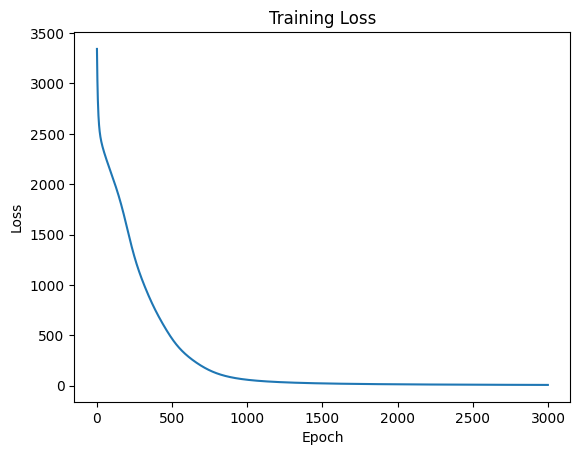

In [6]:
W, H, row_bias, col_bias, losses = model.fit(Xtrain, MASK, plot_loss=True)

# Results

In [7]:
Xtilda = model.predict(W, H, row_bias, col_bias)
Xtilda_bool = model.map_probabilities_to_binary(Xtilda, threshold=0.5)

In [8]:
test_mask = np.zeros(Xtrain.shape).astype("bool")
for x, y in removed_coords:
    test_mask[x,y] = True

In [9]:
for key, value in get_scores(X[test_mask], Xtilda_bool[test_mask]).items():
    print(key, "=", value)

roc_auc = 1.0
pr_auc = 1.0
accuracy = 1.0
f1 = 1.0
precision = 1.0
recall = 1.0
mcc = 1.0
rmse = 0.0


In [10]:
for key, value in get_scores(X[test_mask], Xtilda[test_mask], binary=False).items():
    print(key, "=", value)

roc_auc = 1.0
pr_auc = 1.0
accuracy = None
f1 = None
precision = None
recall = None
mcc = None
rmse = 0.009379555872214364
